In [2]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [3]:
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
# 设置在jupyter中matplotlib的显示情况
%matplotlib inline

In [5]:
## 文件存储路径
path1 = "./datas/C0904.csv"
path2 = "./datas/C0911.csv"
filename = "X12CO2"  # H2O

In [6]:
data = pd.read_csv(path1, header=0)
data.head()

,DateTime,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,WarmBoxTemp,EtalonTemp,...,PPF_res,PPF_base_offset,PPF_slope_offset,PPF_shift,PPF_CH4_conc,PPF_H2O_conc,PPF_C2H6_conc,PPF_C2H4_conc,PPF_NH3_conc,PPF_H2S_conc
0,2016-09-04 00:58:09,247.040389,5928.969335,1.472951e+09,0,963,148.003071,45.00042,45.000739,45.953714,...,0.101604,1.516034,0.478682,0.000077,2.284303,2.625303,-1.419518,0.008766,0.008005,-9.155934
1,2016-09-04 00:58:11,247.040406,5928.969749,1.472951e+09,0,963,148.004130,45.00042,45.000725,45.953728,...,0.101604,1.516034,0.478682,0.000077,2.284303,2.625303,-1.419518,0.008766,0.008005,-9.155934
2,2016-09-04 00:58:11,247.040412,5928.969884,1.472951e+09,0,963,148.001434,45.00042,45.000725,45.953728,...,0.101604,1.516034,0.478682,0.000077,2.284303,2.625303,-1.419518,0.008766,0.008005,-9.155934
3,2016-09-04 00:58:12,247.040418,5928.970020,1.472951e+09,0,963,148.007432,45.00042,45.000725,45.953728,...,0.101604,1.516034,0.478682,0.000077,2.284303,2.625303,-1.419518,0.008766,0.008005,-9.155934
4,2016-09-04 00:58:14,247.040440,5928.970569,1.472951e+09,0,963,147.977097,45.00042,45.000695,45.953750,...,0.091283,1.487520,0.492987,0.000057,2.267714,2.624559,-1.252293,0.007221,0.007496,-11.058096


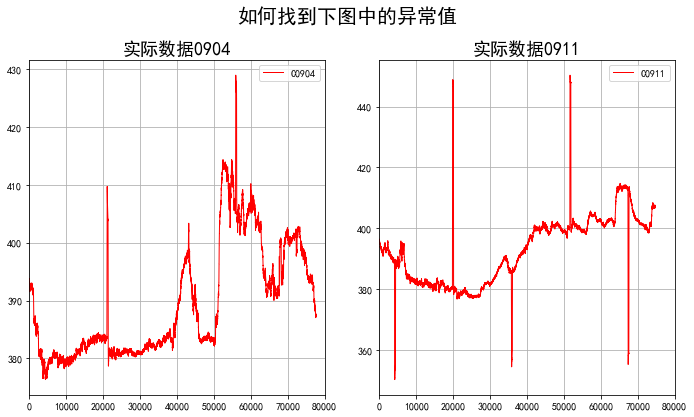

In [7]:
### 原始数据读取
plt.figure(figsize=(10, 6), facecolor='w')
plt.subplot(121)
x = data[filename].values
plt.plot(x, 'r-', lw=1, label=u'C0904')
plt.title(u'实际数据0904', fontsize=18)
plt.legend(loc='upper right')
plt.xlim(0, 80000)
plt.grid(b=True)

plt.subplot(122)
data = pd.read_csv(path2, header=0)
x = data[filename].values
plt.plot(x, 'r-', lw=1, label=u'C0911')
plt.title(u'实际数据0911', fontsize=18)
plt.legend(loc='upper right')
plt.xlim(0, 80000)
plt.grid(b=True)

plt.tight_layout(2, rect=(0, 0, 1, 0.95))
plt.suptitle(u'如何找到下图中的异常值', fontsize=20)
plt.show()

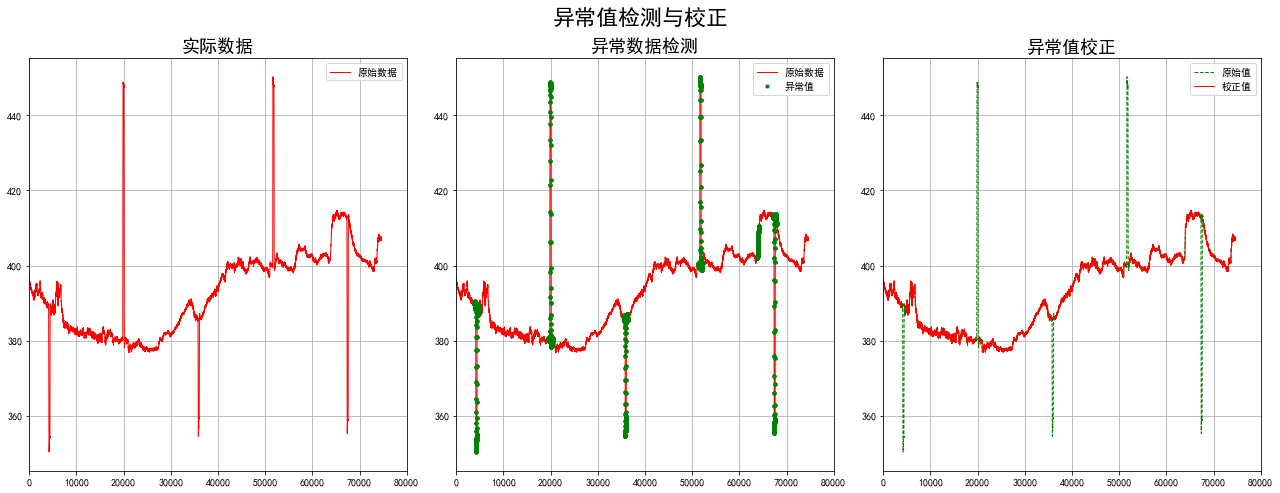

In [8]:
### 异常数据处理
data = pd.read_csv(path2, header=0)
x = data[filename].values

width = 300
delta = 5
eps = 0.02
N = len(x)
p = []
# 异常值存储
abnormal = []
for i in np.arange(0, N-width, delta):
    s = x[i:i+width]
    ## 获取max-min的差值
    min_s = np.min(s)
    ptp = np.ptp(s)  # numpy.ptp() 是计算最大值与最小值差的函数
    ptp_min = ptp / min_s
    p.append(ptp_min)
    ## 如果差值大于给定的阈值认为是
    if ptp_min > eps:
        abnormal.append(range(i, i+width))
## 获得异常的数据x值        
abnormal = np.array(abnormal).flatten()
abnormal = np.unique(abnormal)
#plt.plot(p, lw=1)
#plt.grid(b=True)
#plt.show()

# 所有数据点绘制
plt.figure(figsize=(18, 7), facecolor='w')
plt.subplot(131)
plt.plot(x, 'r-', lw=1, label=u'原始数据')
plt.title(u'实际数据', fontsize=18)
plt.legend(loc='upper right')
plt.xlim(0, 80000)
plt.grid(b=True)

# 异常点绘制
plt.subplot(132)
t = np.arange(N)
plt.plot(t, x, 'r-', lw=1, label=u'原始数据')
plt.plot(abnormal, x[abnormal], 'go', markeredgecolor='g', ms=3, label=u'异常值')
plt.legend(loc='upper right')
plt.title(u'异常数据检测', fontsize=18)
plt.xlim(0, 80000)
plt.grid(b=True)

# 预测
plt.subplot(133)
select = np.ones(N, dtype=np.bool)
select[abnormal] = False
t = np.arange(N)
## 决策树
dtr = DecisionTreeRegressor(criterion='mse', max_depth=10)
br = BaggingRegressor(dtr, n_estimators=10, max_samples=0.3)
## 模型训练
br.fit(t[select].reshape(-1, 1), x[select])
## 模型预测得出结果
y = br.predict(np.arange(N).reshape(-1, 1))
y[select] = x[select]
plt.plot(x, 'g--', lw=1, label=u'原始值')    # 原始值
plt.plot(y, 'r-', lw=1, label=u'校正值')     # 校正值
plt.legend(loc='upper right')
plt.title(u'异常值校正', fontsize=18)
plt.xlim(0, 80000)
plt.grid(b=True)

plt.tight_layout(1.5, rect=(0, 0, 1, 0.95))
plt.suptitle(u'异常值检测与校正', fontsize=22)
plt.show()